<h1> Capstone 3: Processing and Modeling </h1><a id='Capstone_3_Processing_and_Modeling'></a>

## Table of Contents<a id='Table_of_Contents'></a>
* [1 Imports](#Imports)
    * [1.1 Import Libraries](#Import_Libraries)
    * [1.2 Import Data](#Import_Data)
    
* [2 Task](#Task)
* [3 Develop Bag-of-Words Model for Sentiment Analysis](#Develop_Bag-of-Words_Model_for_Sentiment_Analysis) 
    * [3.1 Train-Test Split](#Train-Test_Split)
    * [3.2 Encode Text as Vectors](#Encode_Text_as_Vectors)
    * [3.3 Develop a Multi-Layer Perceptron](#Develop_a_Multi-Layer_Perceptron)
* [4 Predict Tweet Sentiment](#Predict_Tweet_Sentiment)
* [5 Visualizing Results](#Visualizing_Results)
* [6 Topic Modeling](#Topic_Modeling)
    * [6.1 JetBlue Customer Issues Topics](#Customer_Issues_Topics)
    * [6.2 JetBlue Responses Topics](#Airline_Responses_Topics)
* [7 Conclusion](#Conclusion)
* [8 Further Analysis](#Further_Analysis)

## Imports <a id="Imports"></a>

### Import Libraries <a id="Import_Libraries"></a>

In [29]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import pickle
from collections import Counter
import gensim
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from keras.preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Dense

### Import Data <a id="Import_Data"></a>

In [30]:
# airline customer tweets
with open("../data/processed/twcs_dict.pkl", "rb") as pkl_file:
    twcs_dict = pickle.load(pkl_file)

In [31]:
# positive labelled tweets
with open("../data/processed/pos_tweets.pkl", "rb") as pkl_file:
    pos_tweets = pickle.load(pkl_file)

In [32]:
# negative labelled tweets
with open("../data/processed/neg_tweets.pkl", "rb") as pkl_file:
    neg_tweets = pickle.load(pkl_file)

In [33]:
# airline customer service agent tweets
with open("../data/processed/airlines_df.pkl", "rb") as pkl_file:
    airlines_df = pickle.load(pkl_file)

## Task <a id="Task"></a>

In this step I will:

1. develop a neural bag-of-words model for sentiment analysis
    * our training and validation data is the **neg_tweets** and **pos_tweets** lists, which are tweets that have been labelled as positive or negative. The data we will predict on is the dataframes with customer tweets before and after a customer service interaction in **twcs_dict**. 
    * [click here to see the previous notebook in which I process and clean the raw data](https://github.com/bmensah/springboard/blob/main/capstone3/notebooks/Cap3_Wrangling_and_EDA.ipynb)


2. explore differentiating factors between companies that are effective at changing customer sentiment and those that are not


3. apply Latent Dirichlet Allocation (LDA) Topic Modeling on the customer tweets to find out whether there are certain trends that appear in customer issues.

## Develop Bag-of-Words Model for Sentiment Analysis <a id="Develop_Bag-of-Words_Model_for_Sentiment_Analysis"></a>

The labelled tweets were fully processed in the previous notebook. Here, I will split the data into train and validation sets and vectorize. 

#### Positive Tweets

In order to be able to train my model locally, I'm will only use 5% of the available training data.

In [34]:
print("previous length: {:,}".format(len(pos_tweets)))
pos_tweets = pos_tweets[:len(pos_tweets)//20]
print("new length: {:,}".format(len(pos_tweets)))

previous length: 800,000
new length: 40,000


In [35]:
print(pos_tweets[:3])

[['love', 'guys', 'best'], ['im', 'meeting', 'one', 'besties', 'tonight', 'cant', 'wait', 'girl', 'talk'], ['thanks', 'twitter', 'add', 'got', 'meet', 'hin', 'show', 'dc', 'area', 'sweetheart']]


#### Negative Tweets

In [36]:
print("previous length: {:,}".format(len(neg_tweets)))
neg_tweets = neg_tweets[:len(neg_tweets)//20]
print("new length: {:,}".format(len(neg_tweets)))

previous length: 800,000
new length: 40,000


In [37]:
print(neg_tweets[:3])

[['awww', 'thats', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'third', 'day'], ['upset', 'cant', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah'], ['many', 'times', 'ball', 'managed', 'save', 'the', 'rest', 'go', 'bounds']]


### Train-Test Split<a id="Train-Test_Split"></a>

In [38]:
# create labels: 1 is positive, 0 is negative
pos_labels = np.zeros(len(pos_tweets))+1
neg_labels = np.zeros(len(neg_tweets))

In [39]:
# train-test split with 25% of data for testing
split = int(len(pos_tweets)*.75)

X_train = pos_tweets[:split]
X_train.extend(neg_tweets[:split])
X_test = pos_tweets[split:]
X_test.extend(neg_tweets[split:])
y_train = np.append(pos_labels[:split], neg_labels[:split])
y_test = np.append(pos_labels[split:], neg_labels[split:])

In [40]:
lt = ["X_train", "X_test", "y_train", "y_test"]
for arr in lt:
    print(arr+" length: {:,}".format(len(eval(arr))))

X_train length: 60,000
X_test length: 20,000
y_train length: 60,000
y_test length: 20,000


I will now develop a vocabulary based only on the train set to simulate a real scenario in which the test set would not be available. 

In [41]:
vocab = Counter()
for tweet in X_train:
    vocab.update(tweet)

In [42]:
print("most common words:")
vocab.most_common()[:10]

most common words:


[('im', 6250),
 ('good', 3388),
 ('day', 3100),
 ('get', 2988),
 ('like', 2867),
 ('go', 2822),
 ('work', 2624),
 ('going', 2581),
 ('today', 2546),
 ('dont', 2448)]

In [43]:
print("least common words:")
vocab.most_common()[-10:]

least common words:


[('altough', 1),
 ('puedo', 1),
 ('oily', 1),
 ('bane', 1),
 ('hace', 1),
 ('speeches', 1),
 ('fuckkkk', 1),
 ('havta', 1),
 ('dwn', 1),
 ('nooooooooooooooo', 1)]

In [44]:
print("vocab size: {:,} words".format(len(vocab)))

vocab size: 23,028 words


In [45]:
# im is the most common but unlikely to help prediction
del vocab["im"]

# remove words that occur less than 5 times in the vocabulary 
trimmed_vocab = Counter([k for k,v in vocab.items() if v > 5])

# see new size
print("trimmed vocab size: {:,} words".format(len(trimmed_vocab)))

trimmed vocab size: 6,387 words


In [46]:
# remove words not in vocab and join words into one string per document
for i in range(len(X_train)):
    X_train[i] = [w for w in X_train[i] if w in trimmed_vocab]

In [47]:
print(X_train[:5])

[['love', 'guys', 'best'], ['meeting', 'one', 'besties', 'tonight', 'cant', 'wait', 'girl', 'talk'], ['thanks', 'twitter', 'add', 'got', 'meet', 'show', 'dc', 'area', 'sweetheart'], ['being', 'sick', 'really', 'cheap', 'hurts', 'much', 'eat', 'real', 'food', 'plus', 'friends', 'make', 'soup'], ['effect', 'everyone']]


### Encode Text as Vectors<a id="Encode_Text_as_Vectors"></a>

In [48]:
# transform the vocabulary into a list of strings
tokens = [w for w in trimmed_vocab]

# encode vocab
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)

In [49]:
# encode train and test data
X_train_en = tokenizer.texts_to_matrix(X_train, mode="freq")
X_test_en = tokenizer.texts_to_matrix(X_test, mode="freq")

In [50]:
print("train data shape:", X_train_en.shape)
print("test data shape:", X_test_en.shape)

train data shape: (60000, 6388)
test data shape: (20000, 6388)


### Develop a Multi-Layer Perceptron<a id="Develop_a_Multi-Layer_Perceptron"></a>

In [51]:
# create an input layer the same size as the vocabulary
n_words = X_train_en.shape[1]

In [52]:
# create model
model = Sequential()
# define hidden layer
model.add(Dense(50, input_shape=(n_words,), activation="relu"))
# define output layer
model.add(Dense(1, activation="sigmoid"))
# compile
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                319450    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 319,501
Trainable params: 319,501
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.fit(X_train_en, y_train, epochs=10, verbose=1)

Epoch 1/10
1875/1875 [==============================] - 26s 6ms/step - loss: 0.5937 - accuracy: 0.7038
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4622 - accuracy: 0.7858
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4402 - accuracy: 0.7949
Epoch 4/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.4257 - accuracy: 0.8047
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4147 - accuracy: 0.8089
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4027 - accuracy: 0.8154
Epoch 7/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3951 - accuracy: 0.8202
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3853 - accuracy: 0.8256
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3772 - accuracy: 0.8309
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.36

In [54]:
# evaluate
loss, acc = model.evaluate(X_test_en, y_test, verbose=1)

625/625 [==============================] - 2s 2ms/step - loss: 0.5526 - accuracy: 0.7603


This text for this model was encoded using frequency within each document. Now, I will try the other three modes of encoding: 

1. frequency over all documents (tfidf), 
2. binary/onehot encoding, 
3. and count. 

Because of the stochastic nature of neural networks, I will run five trials for each method and choose the encoding scheme that performs the best on average. 

In [55]:
def eval_mode(mode):
    """
    Given an encoding mode - freq, tfidf, binary, or count, 
    define and evaluate the performance of a neural network on
    text encoded with the given mode. 
    """
    # encode according to mode
    X_train_en = tokenizer.texts_to_matrix(X_train, mode=mode)
    X_test_en = tokenizer.texts_to_matrix(X_test, mode=mode)
    # define model
    model = Sequential()
    # define hidden layer
    model.add(Dense(50, input_shape=(n_words,), activation="relu"))
    # define output layer
    model.add(Dense(1, activation="sigmoid"))
    # compile
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    # fit model
    model.fit(X_train_en, y_train, epochs=10, verbose=0)
    # evaluate and return accuracy
    loss, acc = model.evaluate(X_test_en, y_test, verbose=0)
    return acc 

In [56]:
modes = {"freq":[], "tfidf":[],"binary":[],"count":[]}
for i in range(5):
    for mode in modes:
        modes[mode].append(eval_mode(mode))

In [57]:
for mode, scores in modes.items():
    print(mode+":", scores)

freq: [0.7566999793052673, 0.7563499808311462, 0.7597500085830688, 0.7587500214576721, 0.7601500153541565]
tfidf: [0.7368999719619751, 0.7318000197410583, 0.7315000295639038, 0.736549973487854, 0.7271000146865845]
binary: [0.7434499859809875, 0.7450000047683716, 0.7452499866485596, 0.7455999851226807, 0.7463499903678894]
count: [0.7446500062942505, 0.7462499737739563, 0.7402499914169312, 0.7432500123977661, 0.7448499798774719]


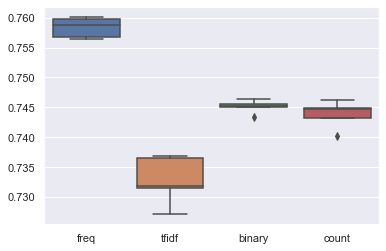

In [58]:
# visualize the score for each mode using a boxplot
mode_dict = pd.DataFrame.from_dict(modes)
sns.boxplot(data=mode_dict);

**freq** is quite clearly the best encoding for this dataset. 

In [59]:
X_train_en = tokenizer.texts_to_matrix(X_train, mode="freq")
X_test_en = tokenizer.texts_to_matrix(X_test, mode="freq")
best_model = Sequential()
# define hidden layer
best_model.add(Dense(50, input_shape=(n_words,), activation="relu"))
# define output layer
best_model.add(Dense(1, activation="sigmoid"))
# compile
best_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
best_model.fit(X_train_en, y_train, epochs=10, verbose=0);

## Predict Tweet Sentiment<a id="Predict_Tweet_Sentiment"></a>

In [60]:
def get_sentiment(text):
    """
    Given a corpus with transformed text, apply the pre-trained model to 
    determine the sentiment of documents with that corpus.
    """
    # process text
    for i in range(len(text)):
        text[i] = " ".join([w for w in text[i] if w in trimmed_vocab])
    encoded = tokenizer.texts_to_matrix(text, mode="freq")
    yhat = best_model.predict(encoded, verbose=0)
    yhat = [round(x[0]) for x in yhat]
    return yhat

In [61]:
# get the sentiment for customer tweets before and after a customer service interaction,
# calculate the percentage of satisfied customers before and after an interaction, 
# calculate the percentage of customers who follow up after getting a response
pct_pre_sent = []
pct_post_sent = []
total_issues = []
pct_followup = []
for airline,dfs in twcs_dict.items():
    # apply neural network to predict sentiment of transformed text
    pre_tweets = dfs["pre"].loc[:,"transformed_text"].to_list()
    pre_sentiment = get_sentiment(pre_tweets)
    post_tweets = dfs["post"].loc[:,"transformed_text"].to_list()
    post_sentiment = get_sentiment(post_tweets)
    # display results
    print("Airline:", airline)
    # find percentage of positive tweets before a customer service interaction
    pre_pct = (sum(pre_sentiment)/len(pre_sentiment))*100
    pct_pre_sent.append(pre_pct)
    print("percent of positive sentiment tweets before customer service interaction: {:.2f}%".format(pre_pct))
    # find percentage of positive tweets after a customer service interaction
    post_pct = (sum(post_sentiment)/len(post_sentiment))*100
    pct_post_sent.append(post_pct)
    print("percent of positive sentiment tweets after customer service interaction: {:.2f}%".format(post_pct))
    # find the difference between pre- and post- interaction sentiment 
    print("change: {:.2f}%".format(post_pct-pre_pct))
    # find the percent of customers who follow up after recieving a reply from a customer service account
    print("number of original issues: {:,}".format(len(pre_tweets)))
    total_issues.append(len(pre_tweets))
    print("number of customers who follow up after their issue has been addressed: {:,}".format(len(post_tweets)))
    pct = (len(post_tweets)/len(pre_tweets))*100
    pct_followup.append(pct)
    print("percent followup: {:.2f}%".format(pct))
    print("------------------")
    print()

Airline: Delta
percent of positive sentiment tweets before customer service interaction: 40.43%
percent of positive sentiment tweets after customer service interaction: 55.81%
change: 15.39%
number of original issues: 11,520
number of customers who follow up after their issue has been addressed: 5,094
percent followup: 44.22%
------------------

Airline: AmericanAir
percent of positive sentiment tweets before customer service interaction: 36.67%
percent of positive sentiment tweets after customer service interaction: 54.17%
change: 17.50%
number of original issues: 11,765
number of customers who follow up after their issue has been addressed: 8,134
percent followup: 69.14%
------------------

Airline: British_Airways
percent of positive sentiment tweets before customer service interaction: 42.07%
percent of positive sentiment tweets after customer service interaction: 59.37%
change: 17.30%
number of original issues: 10,235
number of customers who follow up after their issue has been ad

## Visualizing Results<a id="Visualizing_Results"></a>

To explore what factors may make one airline more successful than another at increasing customer satisfaction after a conversation on Twitter, I will add the following features to a dataframe and explore relationships between them:
* **airline**: the name of the airline
* **pct_pre_sent**: the percentage of customer tweets inbound to an airline that are positive 
* **pct_post_sent**: the percentage of customer tweets replying to a customer service intervention that are positive
* **pct_change**: percent improvement in sentiment (the difference between pct_post_sent and pct_pre_sent)
* **total_issues**: the total number of tweets inbound to an airline from customers
* **pct_followup**: the percentage of customers who follow up after an airline replies to an issue
* **total_tweets**: the total number of tweets by an airline in the original data file
* **avg_tweet_length**: the average length of tweets by a given airline
* **avg_response_time**: the average time it takes for an airline to respond to customer tweets (in hours) 

In [106]:
results_dict = {"airline":list(twcs_dict.keys()), 
            "pct_pre_sent":pct_pre_sent,
            "pct_post_sent":pct_post_sent,
            "total_issues": total_issues,
            "pct_followup":pct_followup}
results_df = pd.DataFrame().from_dict(results_dict)

In [107]:
# add a feature that shows the percent change before and after an interaction
results_df["pct_change"] = results_df["pct_post_sent"] - results_df["pct_pre_sent"]

# add a feature for the total number of tweets from the airline accounts
results_df["total_tweets"] = airlines_df.author_id.value_counts().to_list()

# add a feature for the average tweet length
airlines_df["tweet_length"] = airlines_df["text"].map(lambda x: len(x.split()))
results_df["avg_tweet_length"] = airlines_df.groupby(by="author_id").tweet_length.mean().to_list()

In [108]:
# add a feature for the average response time
# get customer issue tweets (pre tweets) into one dataframe
issues_df = pd.DataFrame(columns=airlines_df.columns)
for airline,dataframes in twcs_dict.items():
    issues_df = issues_df.append(dataframes["pre"])
issues_df.set_index("tweet_id", inplace=True)

# get response times for each tweet 
airlines = list(twcs_dict.keys())
response_times = {airline:[] for airline in airlines}
for tweet in airlines_df.itertuples():
    if pd.notna(tweet.in_response_to_tweet_id):
        idx = int(tweet.in_response_to_tweet_id)
        if idx in issues_df.index:
            response_times[tweet.author_id].append((tweet.created_at - issues_df.loc[idx].created_at).total_seconds())

# get average response times per airline (in hours)
avg_response_time = {k:[np.mean(v)/3600.0] for k,v in response_times.items()}

# append average times to results_df
avg_response_time_df = pd.DataFrame().from_dict(avg_response_time) \
                                   .T.reset_index() \
                                   .rename({"index":"airline", 0:"avg_response_time"}, axis=1)
results_df = pd.merge(results_df, avg_response_time_df, on="airline")

# show final dataframe
results_df

,airline,pct_pre_sent,pct_post_sent,total_issues,pct_followup,pct_change,total_tweets,avg_tweet_length,avg_response_time
0,Delta,40.425347,55.810758,11520,44.218750,15.385411,42253,18.457245,1.123604
1,AmericanAir,36.668083,54.167691,11765,69.137272,17.499608,36764,15.434341,0.337358
2,British_Airways,42.071324,59.373814,10235,51.489985,17.302490,29361,18.415434,4.577548
3,SouthwestAir,45.252971,70.182599,8163,57.025603,24.929629,28977,21.728790,0.429239
4,AirAsiaSupport,65.567207,73.562677,5245,40.457579,7.995470,12829,17.875157,12.030331
5,JetBlue,38.619120,64.894737,2636,72.078907,26.275617,8020,16.997257,2.376467
6,AlaskaAir,43.996203,65.372168,2107,58.661604,21.375965,7478,20.396970,0.142894
7,VirginAtlantic,47.356706,69.977427,1797,73.956594,22.620721,4318,18.234599,0.496372


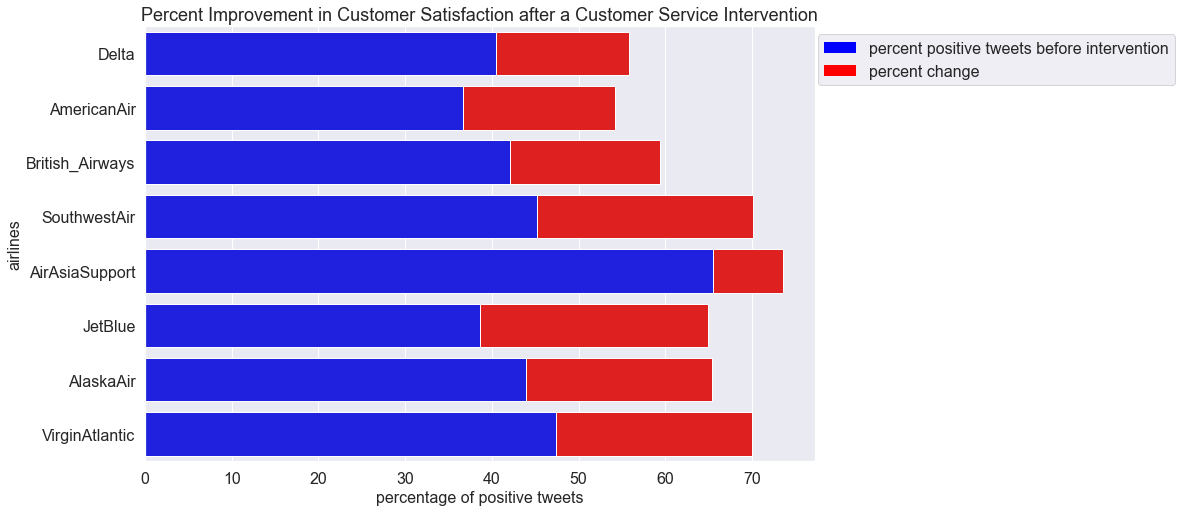

In [119]:
plt.figure(figsize=(12,8))
sns.barplot(x="pct_post_sent", y="airline", color="red", data=results_df)
sns.barplot(x="pct_pre_sent", y="airline", color="blue", data=results_df)
change = plt.Rectangle((0,0),1,1,fc="red", edgecolor = "none")
start = plt.Rectangle((0,0),1,1,fc="blue",  edgecolor = "none")
plt.legend([start, change], ["percent positive tweets before intervention", "percent change"], 
           loc=1, ncol = 1, prop={'size':16}, bbox_to_anchor=(1.55,1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("airlines", fontsize=16)
plt.xlabel("percentage of positive tweets", fontsize=16)
plt.title("Percent Improvement in Customer Satisfaction after a Customer Service Intervention",fontsize=18)
plt.show();

* While AirAsia had the smallest improvement in customer sentiment, it had the most satisfied customers before a customer service interaction. Even with a less than 10% increase in customer satisfaction, AirAsia still boasts the most satisfied customers based on this data.  
* For every airline except for AirAsia and VirginAtlantic, less than 50% of customers sent positive tweets before a customer service interaction. Each of these airlines were able to raise sentiment by at least 15% through a customer service interaction.
* JetBlue was the most effective at improving customer satisfaction, raising the percentage of positive customer tweets by over 26%.

**Caveat:**
There does appear to be a significant improvement in customer sentiment after an intervention by a customer service account on Twitter. However, it is possible that only customers who had a positive experience follow up after a customer service interaction. There is no way to know the sentiment of customers who do not reply after a customer service interaction, or why customers choose not to reply. In this next visualization, we will take a look at the relationship between customer satisfaction and the percentage of customers who follow up after recieving a reply from a customer service account. 

Are the airlines with more tweets in the dataset getting lower sentiment scores simply because there is more data? We will also look at the relationship between the total number of customer tweets inbound to an airline, and the percentage of those tweets that are positive. 

In [110]:
def vis_results(x, title, xlabel, ylabel, y="pct_change", data=results_df, hue="airline", size="total_issues"):
    plt.figure(figsize=(12,8))
    sns.scatterplot(data=data, x=x, y=y, 
                    hue=hue, size=size, sizes=(200,1000), palette="Dark2")
    #plot a line of best fit
    x_val = np.array(results_df[x])
    y_val = np.array(results_df[y])
    m, b = np.polyfit(x_val, y_val, 1)
    plt.plot(x_val, m*x_val + b)
    # create labels for each point
    for x_pos, y_pos, airline in zip(x_val, y_val, results_df["airline"]):
        plt.text(x=x_pos, y=y_pos-1, s=airline)
    # set legend location and label graph
    plt.legend(bbox_to_anchor=(1.2,0.6))
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.show();

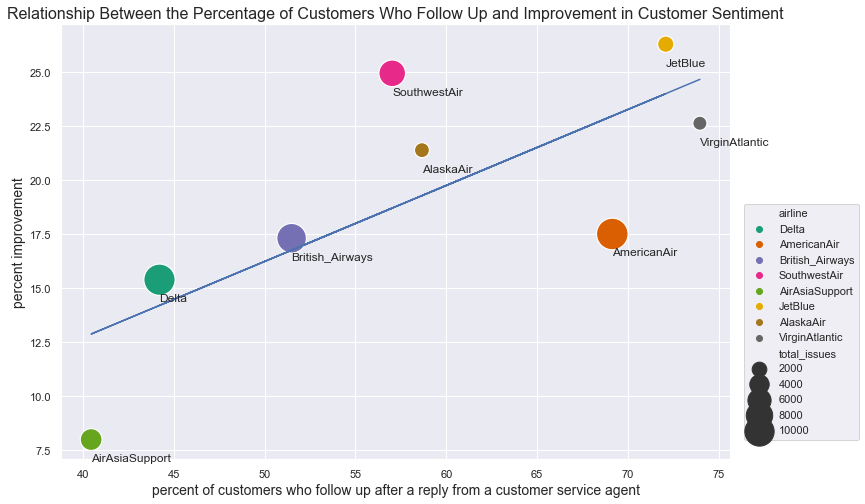

In [111]:
vis_results(x="pct_followup", 
            title="Relationship Between the Percentage of Customers Who Follow Up and Improvement in Customer Sentiment",
            xlabel= "percent of customers who follow up after a reply from a customer service agent",
            ylabel="percent improvement")

* There does appear to be a direct relationship between the amount of customers who followup after a response by an airline customer service account and the percent of customers who are satisfied. This does not necessarily imply that customers who do not respond are unsatisfied, but this should be taken into account when deciding how to interpret how successful customer service interventions on Twitter are. 

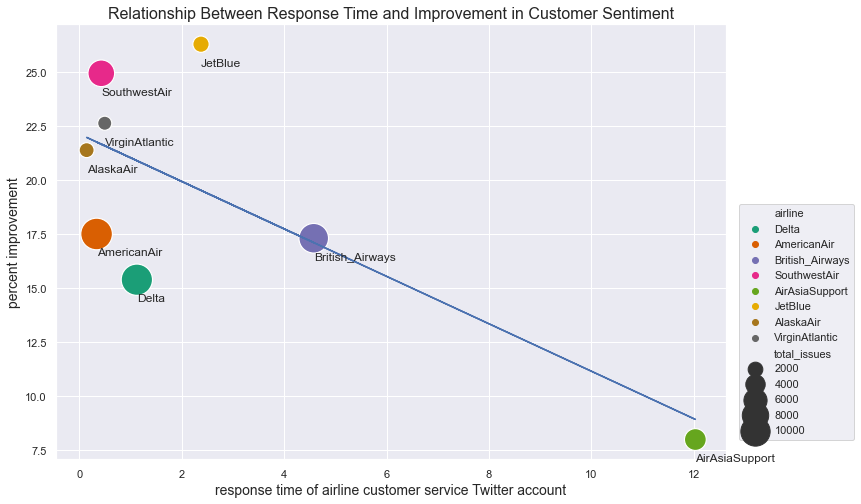

In [112]:
vis_results(x="avg_response_time",
            title="Relationship Between Response Time and Improvement in Customer Sentiment",
            xlabel="response time of airline customer service Twitter account",
            ylabel="percent improvement")

* It appears that there is a strong relationship between responding to customer issues promptly and improving sentiment. 
* However, AirAsia is a major outlier in this data. For airlines that responded in at least two hours, there is quite a bit of variation in how effective the customer service intervention is, with the increase in the percentage of positive tweets ranging from 15% to 26%. 

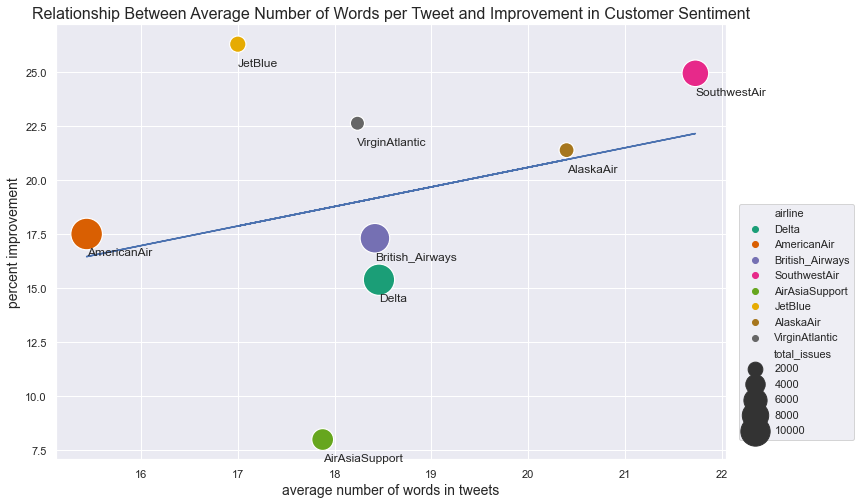

In [113]:
vis_results(x="avg_tweet_length",
            title="Relationship Between Average Number of Words per Tweet and Improvement in Customer Sentiment",
            xlabel="average number of words in tweets",
            ylabel="percent improvement")

* There is a slight relationship between the average number of words per tweet and the increase in the percentage of positive customer tweets. However, it is not exactly clear that the cause of this relationship is. It could be that customers prefer detailed responses. However, this can only be speculated upon without a closer analysis of the unique issues each airline deals with. 

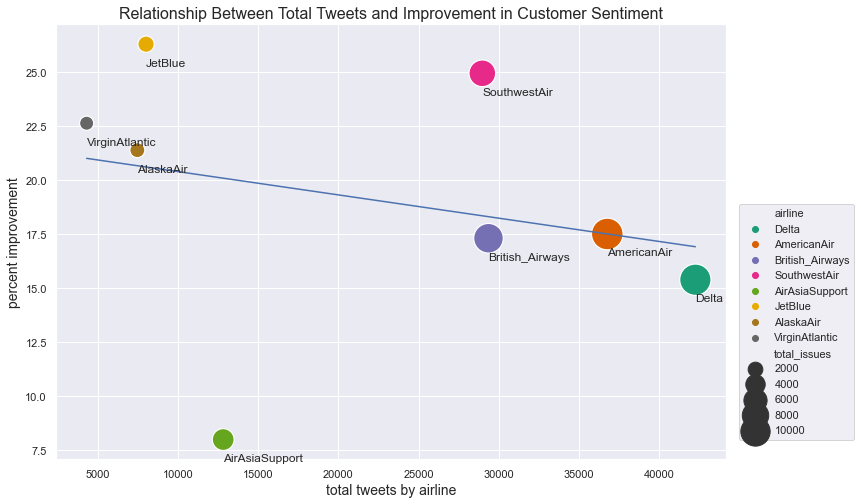

In [114]:
vis_results(x="total_tweets", 
            title="Relationship Between Total Tweets and Improvement in Customer Sentiment",
            xlabel="total tweets by airline",
            ylabel="percent improvement")

* There is a negative relationship between the total number of tweets and airline makes and the increase in the percentage of positive customer tweets. This could be for several reasons:
    * The more tweets it takes for a customers' issue to be resolved, the less likely they are to be content after the interaction. Airlines should aim to resolve issues within as few tweets as possible. 
    * The airlines in the dataset with more data are just more active on Twitter, and therefore customers are more likely to view Twitter as a venue to voice complains. Customers of airlines that are less active on Twitter might be more likely to make a phone call or write an email in order to reach a customer service agent. 
    * The airlines with more data are simply larger airlines, and therefore serve more customers. The more customers you serve, the more diverse the range of issues and the number of issues to resolve is, which could result in a smaller percentage of customers having their issues resolved in a satisfactory way. 

## Topic Modeling<a id="Topic_Modeling"></a>

I will use topic modeling to get a better idea of what issues customers are raising, and how airlines are responding. 

My central purpose in this investigation is to discover how airlines can best use Twitter to improve customer satisfaction. Therefore, I will focus my topic exploration on the airline that was most successful at increasing the percentage of positive customer tweets - JetBlue. 

I will take a look at the topics raised by JetBlue customers as well as the the topics in the airline's customer service agent's responses.

### JetBlue Customer Issues Topics<a id="Customer_Issues_Topics"></a>

In [115]:
def model_topics(corpus, num_topics=4):
    """
    Given a corpus of cleaned and transformed text, as well as a number of topics, 
    use Latent Dirichlet Allocation (LDA) to group documents into topics.  
    """
    dic = gensim.corpora.Dictionary(corpus)
    bow = [dic.doc2bow(doc) for doc in corpus]
    tfidf = gensim.models.TfidfModel(bow) 
    corpus_tfidf = tfidf[bow] 
    lda_model = gensim.models.LdaMulticore(bow,
                                          num_topics=num_topics,
                                          id2word=dic,
                                          passes=10,
                                          workers=2)
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, bow, dic)
    return vis

In [116]:
# get JetBlue customer tweets inbound to customer service account
jb_inbound_corpus = twcs_dict["JetBlue"]["pre"].transformed_text.to_list()
model_topics(jb_inbound_corpus)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.141830  0.033895       1        1  26.132871
2      0.067336 -0.058247       2        1  25.846011
1      0.075586  0.114190       3        1  24.964600
0     -0.001093 -0.089838       4        1  23.056517, topic_info=        Term        Freq       Total Category  logprob  loglift
35   delayed  226.000000  226.000000  Default  30.0000  30.0000
85     thank   91.000000   91.000000  Default  29.0000  29.0000
7      delay   76.000000   76.000000  Default  28.0000  28.0000
130     need  106.000000  106.000000  Default  27.0000  27.0000
96    points   69.000000   69.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
229       us   27.423201   84.534621   Topic4  -5.1944   0.3414
93       get   32.169128  220.085357   Topic4  -5.0348  -0.4558
35   delayed   31.891982  226.950726   Topic4  -5.0434  -0.4952
204     guys   28.070383  119.052876   Topic4  -5.1711   0.0224
135  jetblue   28.534847  160.224225   Topic4  -5.1547  -0.2582

[289 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
265       2  0.135755  account
265       3  0.814532  account
196       1  0.686714  airline
196       2  0.035520  airline
196       3  0.059199  airline
...     ...       ...      ...
60        4  0.012448    would
219       1  0.791371      you
219       2  0.016838      you
219       3  0.168377      you
219       4  0.033675      you

[598 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

The significant topics, in order of most common first, are:
1. Flight delays
    * key words: delayed, miss, reason
2. Flight changes 
    * key words: change, book, seat, boarding, website
3. Concerns with flight experience
    * key words: service, customer, cancelled, money, baggage, wifi, schedule
4. Issues with customer accounts
    * key words: trueblue (JetBlue's frequent flyer program), online, email, points

### JetBlue Responses Topics<a id="Airline_Responses_Topics"></a>

In [117]:
# get JetBlue customer service account responses 
jetblue_responses = airlines_df.loc[airlines_df["author_id"]=="JetBlue", "transformed_text"].to_list()
model_topics(jetblue_responses, 6)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.072346  0.036942       1        1  34.769205
1      0.115544  0.084836       2        1  21.556765
4      0.130014 -0.048907       3        1  17.402754
2      0.167395 -0.090163       4        1  10.256241
5     -0.213373  0.233616       5        1   9.027953
0     -0.271926 -0.216323       6        1   6.987081, topic_info=         Term         Freq        Total Category  logprob  loglift
723    points   464.000000   464.000000  Default  30.0000  30.0000
37         dm   826.000000   826.000000  Default  29.0000  29.0000
35       code   772.000000   772.000000  Default  28.0000  28.0000
53      sorry  1578.000000  1578.000000  Default  27.0000  27.0000
161       you   406.000000   406.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
144        if    73.422595   802.534120   Topic6  -4.2051   0.2696
138  trueblue    67.814940   249.382266   Topic6  -4.2846   1.3589
33     please    70.557306   775.377672   Topic6  -4.2450   0.2642
189      link    67.740030   383.049227   Topic6  -4.2857   0.9286
192      send    64.612301   326.725842   Topic6  -4.3330   1.0404

[357 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
68        1  0.128881   able
68        2  0.649267   able
68        3  0.002432   able
68        4  0.017022   able
68        5  0.201832   able
...     ...       ...    ...
77        1  0.096227  youre
77        2  0.553305  youre
77        3  0.006014  youre
77        4  0.256605  youre
77        5  0.086203  youre

[619 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 3, 6, 1])

JetBlue's replies fell into the following topics, in order of most common first:
1. Addressing issues with reservations
    * key words: code, confirmation, details, reservation
2. Addressing customer experience feedback
    * key words: feedback, hear, appreciate, frustrating, experience, onboard
3. Addressing concerns about costs
    * key words: compensation, fare(s), fee
4. Addressing flight delays
    * key words: delayed, control, traffic, waiting, clearance, weather
5. Addressing concerns about onboard experience
    * key words: inflight, boarding, crewmember, TV
6. Addressing schedule concerns
    * key words: schedule, november, update, P.M., Sunday, September, June 

## Conclusion<a id="Conclusion"></a>

I began with this problem statement: 

**What opportunities exist for airlines to increase customer retention by 5% within one quarter through developing loyalty programs, offering more destinations, or improving brand reputation?**

After isolating tweets from concerned customers and from customer service agents in the [previous notebook](https://github.com/bmensah/springboard/blob/main/capstone3/notebooks/Cap3_Wrangling_and_EDA.ipynb), I began this notebook by training a neural network on tweets with labelled sentiment. I tested four different encoding schemes: frequency within each document (freq), frequency over all documents (tfidf), binary/onehot encoding, and word count and discovered that encoding text using the frequency within each document gave the most accurate results, with 76% accuracy on the test set. 

I used my trained model to predict the sentiment of customer tweets before and after a customer service intervention by an airline. I discovered that for each airline in my dataset, interacting with customers on Twitter led to an improvement in sentiment. The best performing airline was JetBlue, with the percentage of positive tweets increasing by 26%, and AirAsia performed the worst, with the percentage of positive tweets rising by only 8%. However, AirAsia also had the highest percentage of postitive customer tweets before a customer service interaction. AirAsia had the slowest response time. The airline took 12 hours to respond to tweets on average. However, since customers tend to be happy despite this slow response time, I conclude that AirAsia may be dealing with customer service issues in other ways, such as by phone or email. 

I explored four different factors that might be correlated with the change in the percentage of positive tweets: 

1. **the percentage of customers who follow up after getting a response from a customer service agent**
    * There is a positive correlation between the percentage of customers who follow up after getting a response from a customer service agent and the increase in positive sentiment. This correlation could suggest that if customers are not following up after a customer service intervention, they are not satisfied. However, this correlation is not conclusive. Some airlines request that customers send them private direct messages on Twitter on enter a private chat on a different website to discuss issues instead of resolving challenges in public.  


2. **response time**
    * There is a negative correlation between response time and increase in customer satisfaction. Airlines that take longer to respond tend to have a much smaller increase in the percentage of positive tweets.


3. **number of words per tweet**
    * There is a slight relationship between the average number of words per tweet and the increase in satisfaction. This could suggests that customers could be happier when customer service agents provide detailed responses.


4. **total number of tweets**
    * the total number of tweets by an airline is negatively correlated with the increase in the percent of positive tweets. I speculate that this could be for one (or all) of the following reasons:
        * The more tweets it takes for a customers' issue to be resolved, the less likely they are to be content after the interaction. Airlines should aim to resolve issues within as few tweets as possible. 
        * The airlines in the dataset with more data are just more active on Twitter, and therefore customers are more likely to view Twitter as a venue to voice complains. Customers of airlines that are less active on Twitter might be more likely to make a phone call or write an email in order to reach a customer service agent. 
        * The airlines with more data are simply larger airlines, and therefore serve more customers. The more customers you serve, the more diverse the range of issues and the number of issues to resolve is, which may lead to a smaller percentage of customers will have their issues resolved in a satisfactory way. 

Finally, I used Latent Dirichlet Allocation (LDA) to model topics in the customer tweets before a customer service intervention and in the responses from airline accounts. I focused my analysis on the most successful airline, JetBlue. I found that JetBlue customers are mostly concerned about four key areas: flight delays, flight changes, flight experience, and issues with their accounts. This narrow range of concerns suggests that there is potential for the customer service responses to be automated, which would allow human agents to addres more ambiguous concerns. 

## Further Analysis<a id="Further_Analysis"></a>

* Named Entity Recognition (NER) could be used to identify if a customer issues are associated with a particular airport 
* The neural network was 76% accurate on the test set. I only used 5% of the available data (40,000 positive tweets, and 40,000 negative tweets) in order to be able to train and test the network locally. Better accuracy could be achieved by deploying the model on distributed servers over a cloud environment in order to process the full 1.6 million tweet dataset. 
* Time series analysis could be done to identify if there are seasonal trends around certain issues so that airlines can preemptively address concerns customers are likely to have in a given season. 
* While each customer is unique, customer concerns can generally be aggregated into distinct categories. I have shown that JetBlue customer issues can be grouped into 4 major groups (flight delays, flight changes, flight experience, and issues with customer accounts) and that there is significant repetition in JetBlue's responses. Chatbots could be developed to answer some of the issues that are raised repeatedly. This would allow customer service agents to address more nuanced questions, leading to faster response times and higher customer satisfaction. 